In [3]:
import argparse
import os
from zipfile import ZipFile
from urllib.request import urlopen
import shutil
import pandas as pd
from time import time
from datetime import datetime
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.optimizers import Adam
import csv
from keras.models import Model, load_model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K
from skimage.io import imread
from skimage.transform import resize
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
import requests

# Global paths
OUTPUT_DIRECTORY = "./outputs/"
LABEL_DIRECTORY = "./drive/MyDrive/Colab Notebooks/labels/"
MODEL_DIRECTORY = "./models/"
MODEL_GD_ID = "1MRbN5hXOTYnw7-71K-2vjY01uJ9GkQM5"
MODEL_ZIP_FILE = "./models/models.zip"
IMG_DIRECTORY = "./images/"
IMG_GD_ID = "1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj"
IMG_ZIP_FILE = "./images/images.zip"

# Global variables
RAW_IMG_SIZE = (256, 256)
IMG_SIZE = (224, 224)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
MAX_EPOCH = 50
BATCH_SIZE = 32
FOLDS = 5
STOPPING_PATIENCE = 32
LR_PATIENCE = 16
INITIAL_LR = 0.0001

CLASSES = ["0", "1", "2", "3", "4", "5", "6", "7", "8"]
CLASS_NAMES = ['Chinee Apple',
               'Lantana',
               'Parkinsonia',
               'Parthenium',
               'Prickly Acacia',
               'Rubber Vine',
               'Siam Weed',
               'Snake Weed',
               'Negatives']


def download_google_drive_file(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params={'id': id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)


def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None


def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)


def parse_args():
    parser = argparse.ArgumentParser(description='Train and test ResNet50, InceptionV3, or custom model on DeepWeeds.')
    parser.add_argument("command", default='train', help="'cross_validate' or 'inference'")
    parser.add_argument('--model', default='resnet', help="'resnet', 'inception', or path to .hdf5 file.")
    args = parser.parse_args()
    return args.command, args.model


def download_images():
    if not os.path.exists(IMG_DIRECTORY):
        os.makedirs(IMG_DIRECTORY)
        print("Downloading DeepWeeds images to " + IMG_ZIP_FILE)
        download_google_drive_file(IMG_GD_ID, IMG_ZIP_FILE)
        print("Finished downloading images.")
        print("Unzipping " + IMG_ZIP_FILE)
        with ZipFile(IMG_ZIP_FILE, "r") as zip_ref:
            zip_ref.extractall(IMG_DIRECTORY)
        print("Finished unzipping images.")


def download_models():
    if not os.path.exists(MODEL_DIRECTORY):
        os.makedirs(MODEL_DIRECTORY)
        print("Downloading DeepWeeds models to " + MODEL_ZIP_FILE)
        download_google_drive_file(MODEL_GD_ID, MODEL_ZIP_FILE)
        print("Finished downloading models.")
        print("Unzipping " + MODEL_ZIP_FILE)
        with ZipFile(MODEL_ZIP_FILE, "r") as zip_ref:
            zip_ref.extractall(MODEL_DIRECTORY)
        print("Finished unzipping models.")


def crop(img, size):
    """
    Crop the image concentrically to the desired size.
    :param img: Input image
    :param size: Required crop image size
    :return:
    """
    (h, w, c) = img.shape
    x = int((w - size[0]) / 2)
    y = int((h - size[1]) / 2)
    return img[y:(y + size[1]), x:(x + size[0]), :]


def crop_generator(batches, size):
    """
    Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator
    :param batches: Batches of images to be cropped
    :param size: Size to be cropped to
    :return:
    """
    while True:
        batch_x, batch_y = next(batches)
        (b, h, w, c) = batch_x.shape
        batch_crops = np.zeros((b, size[0], size[1], c))
        for i in range(b):
            batch_crops[i] = crop(batch_x[i], (size[0], size[1]))
        yield (batch_crops, batch_y)


def inference(model):
    # Create new output directory for saving inference times
    timestamp = datetime.fromtimestamp(time()).strftime('%Y%m%d-%H%M%S')
    output_directory = "{}{}/".format(OUTPUT_DIRECTORY, timestamp)
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Load DeepWeeds dataframe
    dataframe = pd.read_csv(LABEL_DIRECTORY + "labels.csv")
    image_count = dataframe.shape[0]
    filenames = dataframe.Filename

    preprocessing_times = []
    inference_times = []
    for i in range(image_count):
        # Load image
        start_time = time()
        img = imread(IMG_DIRECTORY + filenames[i])
        # Resize to 224x224
        img = resize(img, (224, 224))
        # Map to batch
        img = np.expand_dims(img, axis=0)
        # Scale from int to float
        img = img * 1. / 255
        preprocessing_time = time() - start_time
        start_time = time()
        # Predict label
        prediction = model.predict(img, batch_size=1, verbose=0)
        y_pred = np.argmax(prediction, axis=1)
        y_pred[np.max(prediction, axis=1) < 1 / 9] = 8
        inference_time = time() - start_time
        # Append times to lists
        preprocessing_times.append(preprocessing_time)
        inference_times.append(inference_time)

    # Save inference times to csv
    with open(output_directory + "tf_inference_times.csv", 'w', newline='') as file:
        writer = csv.writer(file, delimiter=',')
        writer.writerow(['Filename', 'Preprocessing time (ms)', 'Inference time (ms)'])
        for i in range(image_count):
            writer.writerow([filenames[i], preprocessing_times[i] * 1000, inference_times[i] * 1000])

model = "inception"
command = "cross_validate"

  # Download images and models (if necessary)
download_images()
download_models()


k=1
# Create new output directory for individual folds from timestamp
timestamp = datetime.fromtimestamp(time()).strftime('%Y%m%d-%H%M%S')
print('Fold {}/{} - {}'.format(k + 1, FOLDS, timestamp))
output_directory = "{}{}/".format(OUTPUT_DIRECTORY, timestamp)
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

# Prepare training, validation and testing labels for kth fold
train_label_file = "{}train_subset{}.csv".format(LABEL_DIRECTORY, k)
val_label_file = "{}val_subset{}.csv".format(LABEL_DIRECTORY, k)
test_label_file = "{}test_subset{}.csv".format(LABEL_DIRECTORY, k)
train_dataframe = pd.read_csv(train_label_file,dtype=str)
val_dataframe = pd.read_csv(val_label_file,dtype=str)
test_dataframe = pd.read_csv(test_label_file,dtype=str)
train_image_count = train_dataframe.shape[0]
val_image_count = train_dataframe.shape[0]
test_image_count = test_dataframe.shape[0]

# Training image augmentation
train_data_generator = ImageDataGenerator(
  rescale=1. / 255,
  fill_mode="constant",
  shear_range=0.2,
  zoom_range=(0.5, 1),
  horizontal_flip=True,
  rotation_range=360,
  channel_shift_range=25,
  brightness_range=(0.75, 1.25))

# Validation image augmentation
val_data_generator = ImageDataGenerator(
  rescale=1. / 255,
  fill_mode="constant",
  shear_range=0.2,
  zoom_range=(0.5, 1),
  horizontal_flip=True,
  rotation_range=360,
  channel_shift_range=25,
  brightness_range=(0.75, 1.25))

# No testing image augmentation (except for converting pixel values to floats)
test_data_generator = ImageDataGenerator(rescale=1. / 255)

# Load train images in batches from directory and apply augmentations
train_data_generator = train_data_generator.flow_from_dataframe(
  train_dataframe,
  IMG_DIRECTORY,
  x_col="Filename",
  y_col="Label",
  target_size=RAW_IMG_SIZE,
  batch_size=BATCH_SIZE,
  has_ext=True,
  classes=CLASSES,
  class_mode='categorical')

# Load validation images in batches from directory and apply rescaling
val_data_generator = val_data_generator.flow_from_dataframe(
  val_dataframe,
  IMG_DIRECTORY,
  x_col="Filename",
  y_col="Label",
  target_size=RAW_IMG_SIZE,
  batch_size=BATCH_SIZE,
  has_ext=True,
  classes=CLASSES,
  class_mode='categorical')

# Load test images in batches from directory and apply rescaling
test_data_generator = test_data_generator.flow_from_dataframe(
  test_dataframe,
  IMG_DIRECTORY,
  x_col="Filename",
  y_col="Label",
  target_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  has_ext=True,
  shuffle=False,
  classes=CLASSES,
  class_mode='categorical')

# Crop augmented images from 256x256 to 224x224
train_data_generator = crop_generator(train_data_generator, IMG_SIZE)
val_data_generator = crop_generator(val_data_generator, IMG_SIZE)

model_name = "inception"

# Load ImageNet pre-trained model with no top, either InceptionV3 or ResNet50
if model_name == "resnet":
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
elif model_name == "inception":
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
x = base_model.output
# Add a global average pooling layer
x = GlobalAveragePooling2D(name='avg_pool')(x)
# Add fully connected output layer with sigmoid activation for multi label classification
outputs = Dense(len(CLASSES), activation='sigmoid', name='fc9')(x)
# Assemble the modified model
model = Model(inputs=base_model.input, outputs=outputs)

# Checkpoints for training
model_checkpoint = ModelCheckpoint(output_directory + "lastbest-0.hdf5", verbose=1, save_best_only=True)

early_stopping = EarlyStopping(patience=STOPPING_PATIENCE, restore_best_weights=True)
tensorboard = TensorBoard(log_dir=output_directory, histogram_freq=0, write_graph=True, write_images=False)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.5, patience=LR_PATIENCE, min_lr=0.000003125)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=INITIAL_LR), metrics=['categorical_accuracy'])
csv_logger = CSVLogger(output_directory + "training_metrics.csv")




history = model.fit(
      train_data_generator,
      steps_per_epoch=train_image_count // BATCH_SIZE,
      epochs=MAX_EPOCH,
      validation_data=val_data_generator,
      validation_steps=val_image_count // BATCH_SIZE,
      callbacks=[tensorboard, model_checkpoint, early_stopping, reduce_lr, csv_logger],
      shuffle=False)

Finished downloading images.
Unzipping ./images/images.zip
Finished unzipping images.
Finished downloading models.
Unzipping ./models/models.zip
Finished unzipping models.
Fold 2/5 - 20210430-082214
Found 10504 validated image filenames belonging to 9 classes.
Found 3502 validated image filenames belonging to 9 classes.
Found 3503 validated image filenames belonging to 9 classes.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Epoch 1/50
328/328 [==============================] - 376s 1s/step - loss: 0.2856 - categorical_accuracy: 0.5681 - val_loss: 0.1161 - val_categorical_accuracy: 0.7987

Epoch 00001: val_loss improved from inf to 0.11607, saving model to ./outputs/20210430-082214/lastbest-0.hdf5
Epoch 2/50
328/328 [==============================] - 357s 1s/step - loss: 0.1089 - categorical_accuracy: 0.8118 - val_loss: 0.0980 - val_categorical_accuracy: 0.8331

Epoch 00002: val_loss improved from 0.11607 to 0.09796, saving model to ./outputs/20210430-082214/lastbest-0.hdf5
Epoch 3/50
328/328 [==============================] - 355s 1s/step - loss: 0.0863 - categorical_accuracy: 0.8547 - val_loss: 0.0853 - val_categorical_accuracy: 0.8579

Epoch 00003: val_loss improved from 0.09796 to 0.08531, saving model to ./outputs/20210430-082214/lastbest-0.hdf5
Epoch 4/50
328/328 [==============================] - 357s 1s/step - loss: 0.0728 - categorical_accuracy: 0.8795 - val_loss: 0.0808 - val_categorical_accuracy

# New Section

                precision    recall  f1-score   support

  Chinee Apple       0.91      0.74      0.82       225
       Lantana       0.84      0.92      0.88       213
   Parkinsonia       0.99      0.88      0.93       206
    Parthenium       0.74      0.97      0.84       205
Prickly Acacia       0.86      0.91      0.89       213
   Rubber Vine       0.97      0.94      0.96       202
     Siam Weed       0.90      0.99      0.94       215
    Snake Weed       0.87      0.84      0.85       203
     Negatives       0.96      0.94      0.95      1821

      accuracy                           0.92      3503
     macro avg       0.89      0.90      0.89      3503
  weighted avg       0.92      0.92      0.92      3503

[[ 167    9    0   11    2    0    2   13   21]
 [   1  196    0    0    0    0    6    2    8]
 [   0    0  181    2    7    0    0    0   16]
 [   0    1    0  198    2    0    0    0    4]
 [   0    0    1   11  194    0    0    0    7]
 [   1    3    0    1    0  1

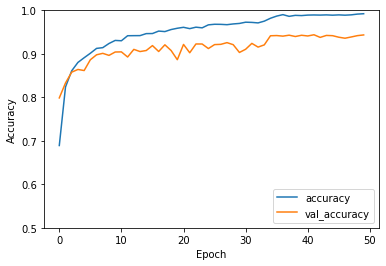

In [5]:
predictions = model.predict(test_data_generator, test_image_count // BATCH_SIZE + 1)


y_true = test_data_generator.classes
y_pred = np.argmax(predictions, axis=1)
y_pred[np.max(predictions, axis=1) < 1 / 9] = 8  # Assign predictions worse than random guess to negative class

y_true = [str(int) for int in y_true]
y_pred = np.array([str(i).split('.')[0] for i in y_pred])

# Generate and print classification metrics and confusion matrix
print(classification_report(y_true, y_pred, labels=CLASSES, target_names=CLASS_NAMES))
report = classification_report(y_true, y_pred, labels=CLASSES, target_names=CLASS_NAMES, output_dict=True)
with open(output_directory + 'classification_report.csv', 'w') as f:
    for key in report.keys():
        f.write("%s,%s\n" % (key, report[key]))
conf_arr = confusion_matrix(y_true, y_pred, labels=CLASSES)
print(conf_arr)
np.savetxt(output_directory + "confusion_matrix.csv", conf_arr, delimiter=",")


print(type(y_pred))
print(type(y_true))

import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_data_generator, verbose=1)

print(test_acc)

model.summary()

In [6]:
!mv "/content/outputs/20210430-082214" "/content/drive/MyDrive/Colab Notebooks/h5"